<a href="https://colab.research.google.com/github/javier06github/Desafio_ONE_TelecomX/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd

# Asegurate de usar la ruta correcta
file_path = "/content/drive/MyDrive/Colab Notebooks/TelecomX_Data.json"
df = pd.read_json(file_path)
df.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformación

In [7]:

df = pd.json_normalize(df.to_dict(orient="records"))


df_clean = df.copy()


categorical_cols = df_clean.select_dtypes(include="object").columns
df_clean[categorical_cols] = df_clean[categorical_cols].fillna("unknown")


for col in categorical_cols:
    df_clean[col] = df_clean[col].str.lower().str.strip()


df_clean.drop_duplicates(inplace=True)


print("✔ Valores nulos restantes:", df_clean.isnull().sum().sum())
print("✔ Duplicados eliminados:", df_clean.duplicated().sum())
print("✔ DataFrame final:", df_clean.shape)


✔ Valores nulos restantes: 0
✔ Duplicados eliminados: 0
✔ DataFrame final: (7267, 21)


In [8]:
# Crear columna "account.Charges.Daily" como facturación mensual dividida por 30 días
df_clean["account.Charges.Daily"] = df_clean["account.Charges.Monthly"] / 30

# Mostrar algunas filas para verificar
df_clean[["account.Charges.Monthly", "account.Charges.Daily"]].head()


,account.Charges.Monthly,account.Charges.Daily
0,65.6,2.186667
1,59.9,1.996667
2,73.9,2.463333
3,98.0,3.266667
4,83.9,2.796667


In [9]:
import numpy as np

# Copia del DataFrame limpio
df_std = df_clean.copy()

# 1. Convertimos nombres de columnas a minúsculas
df_std.columns = df_std.columns.str.lower()

# 2. Mapeo binario: yes → 1, no → 0, unknown → -1
binarios_map = {'yes': 1, 'no': 0, 'unknown': -1}

# 3. Detectamos columnas que contengan esos valores
cols_a_mapeo = [
    col for col in df_std.columns
    if df_std[col].dropna().astype(str).str.lower().isin(['yes', 'no', 'unknown']).any()
]

# 4. Aplicamos el mapeo binario
for col in cols_a_mapeo:
    df_std[col] = df_std[col].map(lambda x: binarios_map.get(str(x).lower(), x))



# 6. Crear columna daily charges si no existe
if "account.charges.monthly" in df_std.columns and "account.charges.daily" not in df_std.columns:
    df_std["account.charges.daily"] = df_std["account.charges.monthly"] / 30

# 7. Reemplazar -1 por NaN para análisis estadístico correcto
df_std.replace(-1, np.nan, inplace=True)

# 8. Vista previa
df_std.head()


,customerid,churn,customer.gender,customer.seniorcitizen,customer.partner,customer.dependents,customer.tenure,phone.phoneservice,phone.multiplelines,internet.internetservice,...,internet.deviceprotection,internet.techsupport,internet.streamingtv,internet.streamingmovies,account.contract,account.paperlessbilling,account.paymentmethod,account.charges.monthly,account.charges.total,account.charges.daily
0,0002-orfbo,0,female,0,1,1,9,1,0,dsl,...,0,1,1,0,one year,1,mailed check,65.6,593.3,2.186667
1,0003-mknfe,0,male,0,0,0,9,1,1,dsl,...,0,0,0,1,month-to-month,0,mailed check,59.9,542.4,1.996667
2,0004-tlhlj,1,male,0,0,0,4,1,0,fiber optic,...,1,0,0,0,month-to-month,1,electronic check,73.9,280.85,2.463333
3,0011-igkff,1,male,1,1,0,13,1,0,fiber optic,...,1,0,1,1,month-to-month,1,electronic check,98.0,1237.85,3.266667
4,0013-exchz,1,female,1,1,0,3,1,0,fiber optic,...,0,1,1,0,month-to-month,1,mailed check,83.9,267.4,2.796667


#📊 Carga y análisis

In [10]:
# 1. Estadísticas descriptivas generales (solo columnas numéricas)
df_std.describe()


,customer.seniorcitizen,customer.partner,customer.dependents,customer.tenure,phone.phoneservice,account.paperlessbilling,account.charges.monthly,account.charges.daily
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,0.162653,0.484106,0.300124,32.346498,0.902711,0.593230,64.720098,2.157337
std,0.369074,0.499782,0.458343,24.571773,0.296371,0.491265,30.129572,1.004319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.608333
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.425000,1.180833
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.300000,2.343333
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.875000,2.995833
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,3.958333


In [11]:
# 2. Calcular la mediana
df_std.median(numeric_only=True)


,0
customer.seniorcitizen,0.000000
customer.partner,0.000000
customer.dependents,0.000000
customer.tenure,29.000000
phone.phoneservice,1.000000
account.paperlessbilling,1.000000
account.charges.monthly,70.300000
account.charges.daily,2.343333


In [12]:
# 3. Ver cantidad de valores nulos por columna
df_std.isnull().sum()


,0
customerid,0
churn,0
customer.gender,0
customer.seniorcitizen,0
customer.partner,0
customer.dependents,0
customer.tenure,0
phone.phoneservice,0
phone.multiplelines,0
internet.internetservice,0


In [13]:
# 4. Ver tipo de datos de cada columna
df_std.dtypes


,0
customerid,object
churn,object
customer.gender,object
customer.seniorcitizen,int64
customer.partner,int64
customer.dependents,int64
customer.tenure,int64
phone.phoneservice,int64
phone.multiplelines,object
internet.internetservice,object


In [14]:
# 1. Eliminar caracteres no numéricos en 'account.charges.total' y convertir a float
df_std['account.charges.total'] = (
    df_std['account.charges.total']
    .astype(str)
    .str.replace('[^\d\.]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

# 2. Redondear columnas numéricas a 2 decimales (solo para visualización o exportación)
cols_numericas = df_std.select_dtypes(include=['float64', 'int64']).columns
df_std[cols_numericas] = df_std[cols_numericas].round(2)

# Verificar tipos actualizados
print(df_std.dtypes)


customerid                    object
churn                         object
customer.gender               object
customer.seniorcitizen         int64
customer.partner               int64
customer.dependents            int64
customer.tenure                int64
phone.phoneservice             int64
phone.multiplelines           object
internet.internetservice      object
internet.onlinesecurity       object
internet.onlinebackup         object
internet.deviceprotection     object
internet.techsupport          object
internet.streamingtv          object
internet.streamingmovies      object
account.contract              object
account.paperlessbilling       int64
account.paymentmethod         object
account.charges.monthly      float64
account.charges.total        float64
account.charges.daily        float64
dtype: object


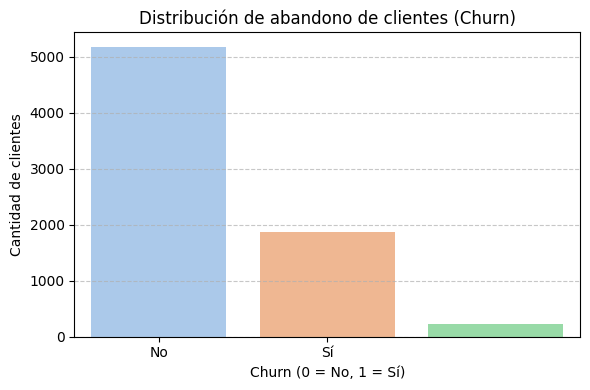

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='churn', hue='churn', data=df_std, palette='pastel', legend=False)

plt.title("Distribución de abandono de clientes (Churn)")
plt.xlabel("Churn (0 = No, 1 = Sí)")
plt.ylabel("Cantidad de clientes")
plt.xticks([0, 1], ["No", "Sí"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


churn
0    5174
1    1869
      224
Name: count, dtype: int64


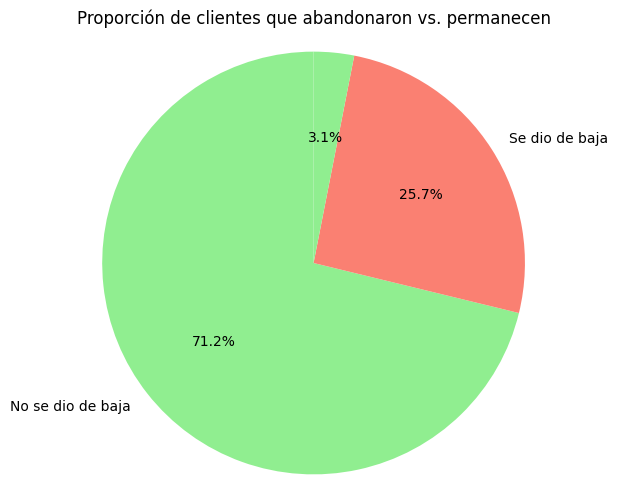

In [16]:
# Verificamos los valores únicos de churn
print(df_std['churn'].value_counts(dropna=False))

# Etiquetas automáticas según los valores presentes
labels_dict = {0: "No se dio de baja", 1: "Se dio de baja"}

# Conteo y etiquetas desde los valores reales
churn_counts = df_std['churn'].value_counts()
labels = [labels_dict.get(k, str(k)) for k in churn_counts.index]

# Gráfico pie chart
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=labels,
        autopct="%1.1f%%", startangle=90, colors=['lightgreen', 'salmon'])
plt.title("Proporción de clientes que abandonaron vs. permanecen")
plt.axis('equal')
plt.show()




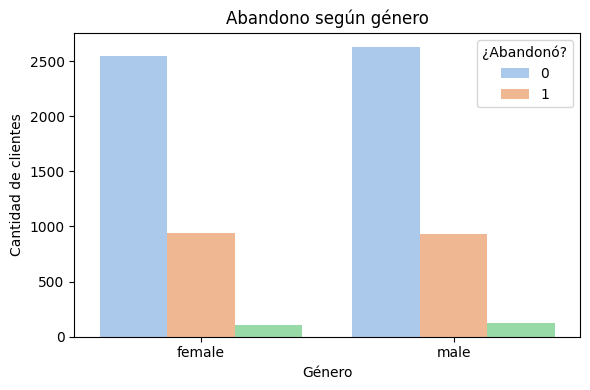

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_std, x='customer.gender', hue='churn', palette='pastel')
plt.title("Abandono según género")
plt.xlabel("Género")
plt.ylabel("Cantidad de clientes")
plt.legend(title="¿Abandonó?")
plt.tight_layout()
plt.show()



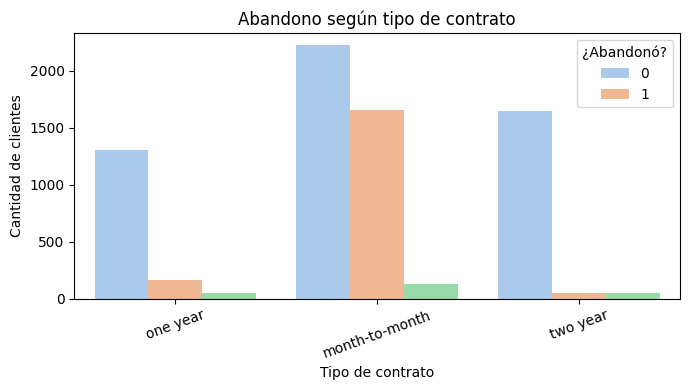

In [18]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df_std, x='account.contract', hue='churn', palette='pastel')
plt.title("Abandono según tipo de contrato")
plt.xlabel("Tipo de contrato")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=20)
plt.legend(title="¿Abandonó?")
plt.tight_layout()
plt.show()


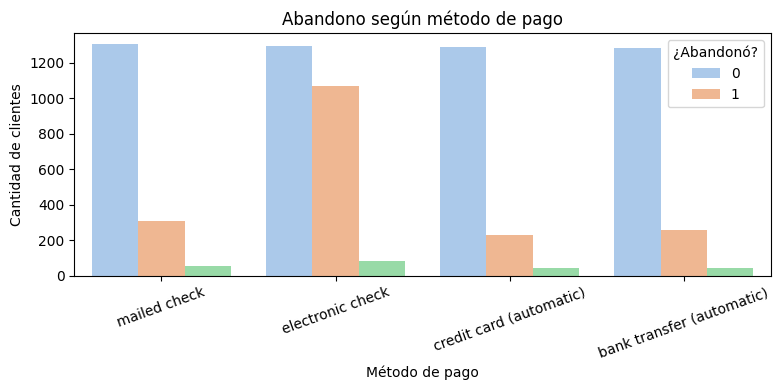

In [19]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_std, x='account.paymentmethod', hue='churn', palette='pastel')
plt.title("Abandono según método de pago")
plt.xlabel("Método de pago")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=20)
plt.legend(title="¿Abandonó?")
plt.tight_layout()
plt.show()



In [20]:
def calcular_tasa_abandono(df, column):
    resumen = df.groupby(column)['churn'].mean().reset_index()
    resumen.columns = [column, 'tasa_abandono']
    resumen['tasa_abandono'] = resumen['tasa_abandono'] * 100  # convertir a porcentaje
    resumen = resumen.sort_values('tasa_abandono', ascending=False)
    return resumen


/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


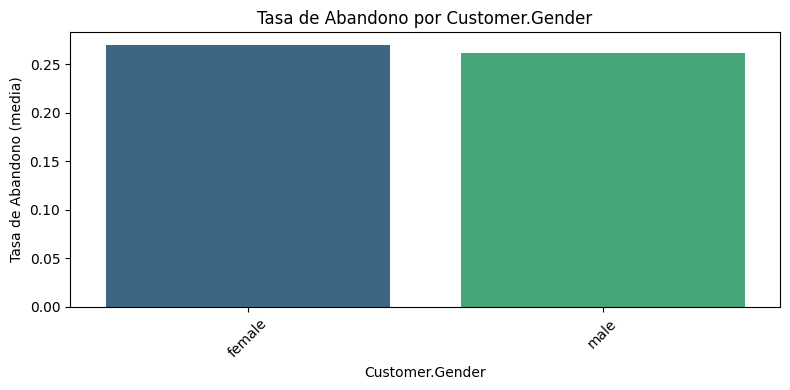

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


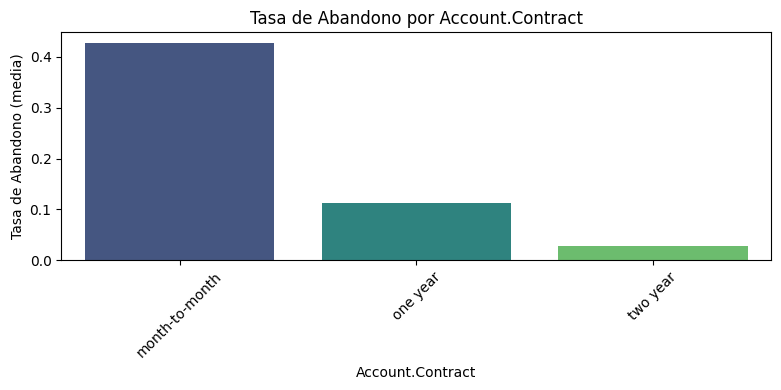

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


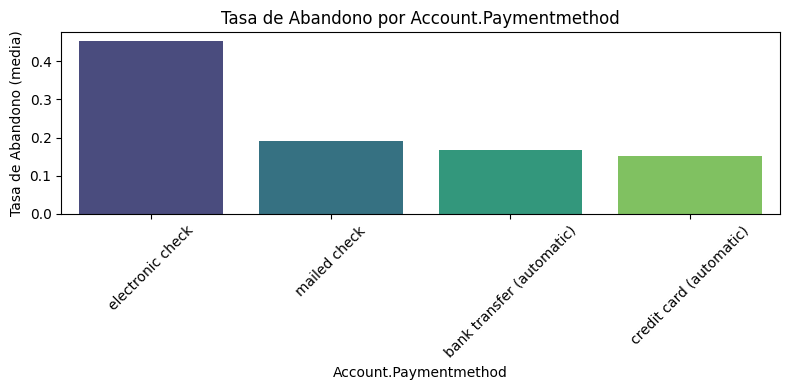

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


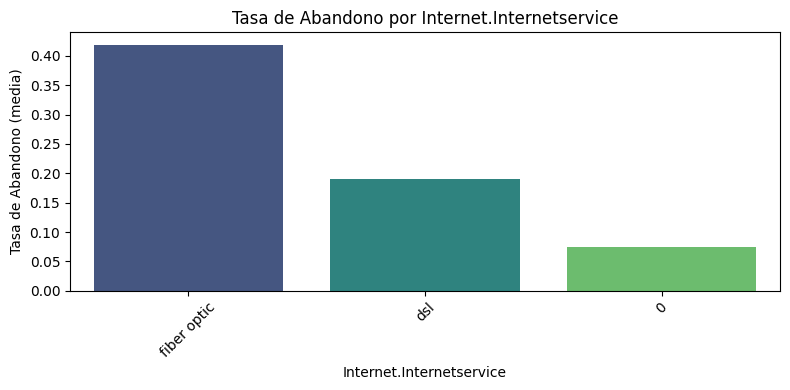

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


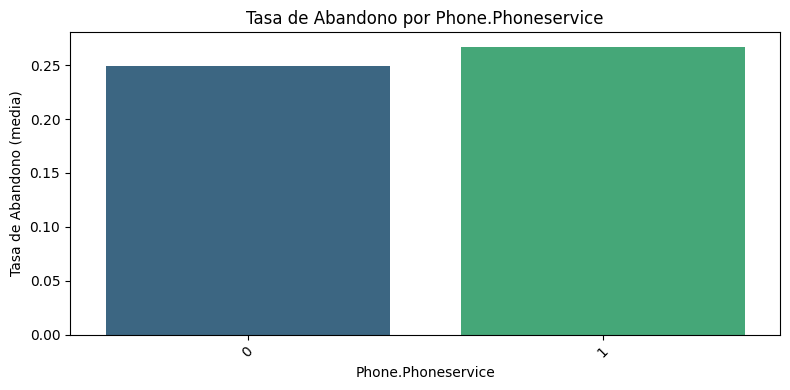

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


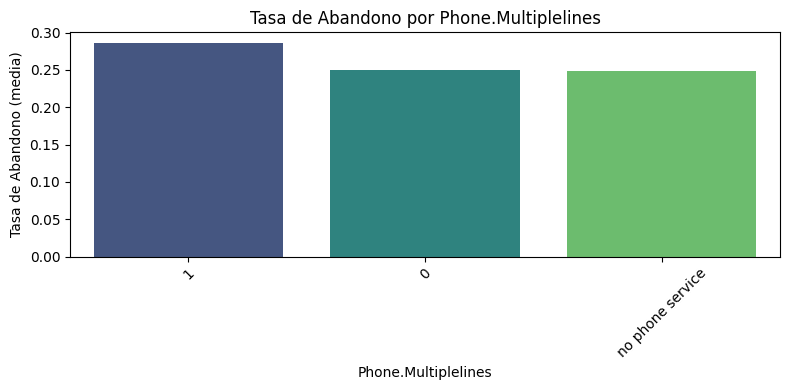

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


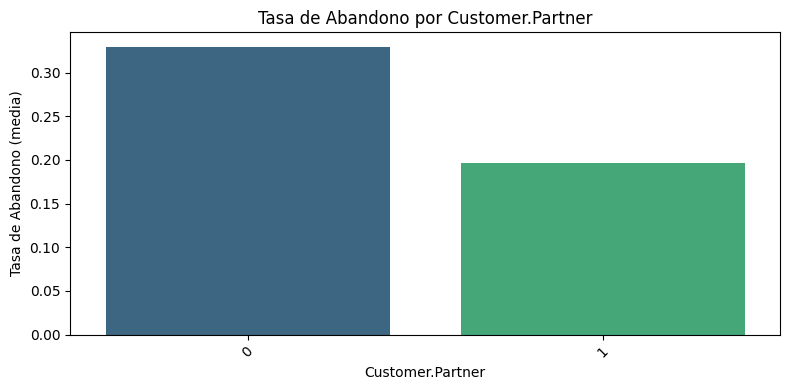

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


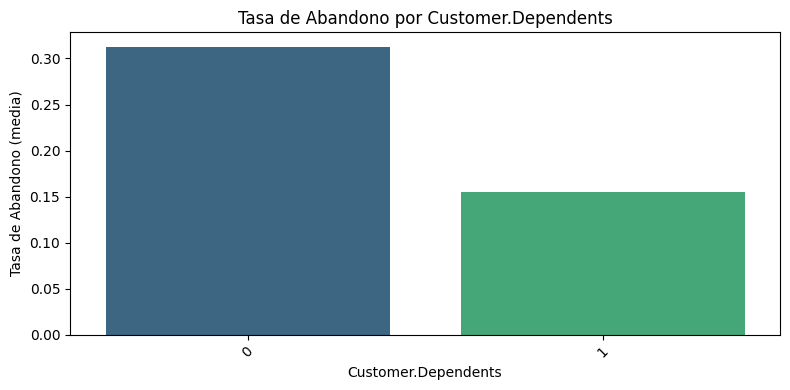

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


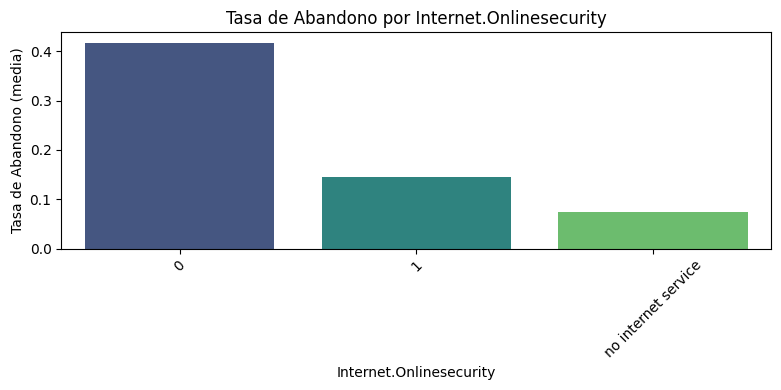

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


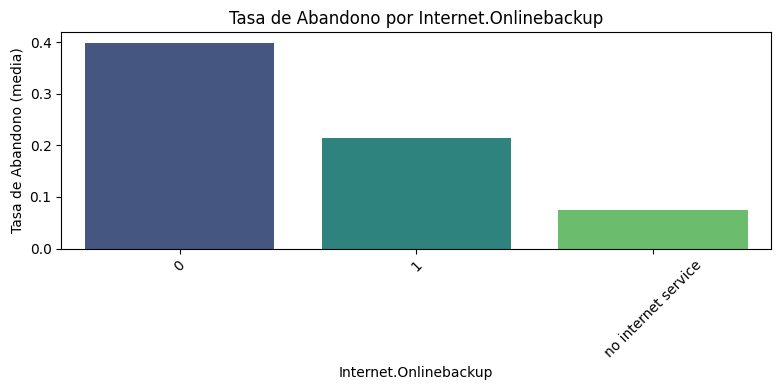

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


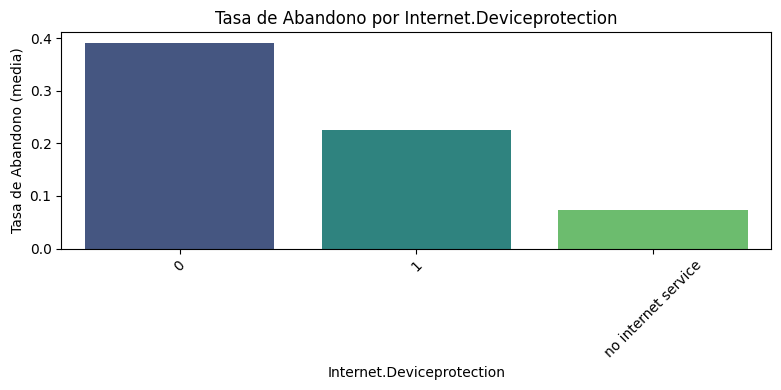

/tmp/ipython-input-21-2141178824.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")


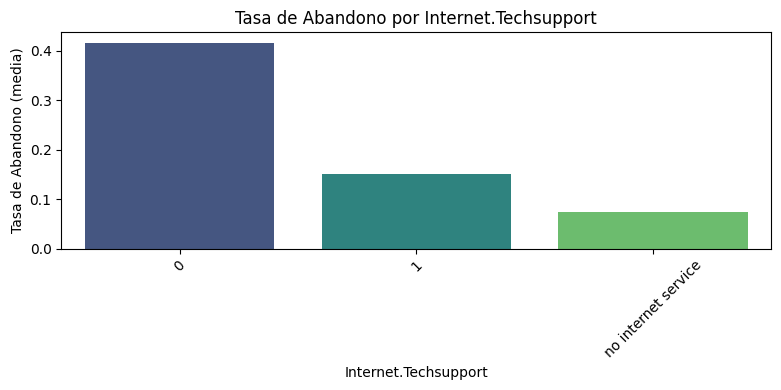

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarse de que la columna 'churn' sea numérica (por si quedó mal codificada)
df_std["churn"] = pd.to_numeric(df_std["churn"], errors="coerce")

# Variables categóricas que queremos comparar
variables_categoricas = [
    'customer.gender', 'account.contract', 'account.paymentmethod',
    'internet.internetservice', 'phone.phoneservice', 'phone.multiplelines',
    'customer.partner', 'customer.dependents', 'internet.onlinesecurity',
    'internet.onlinebackup', 'internet.deviceprotection', 'internet.techsupport'
]

# Filtrar columnas válidas para análisis (categóricas o con pocos valores únicos)
variables_validas = [
    col for col in variables_categoricas
    if df_std[col].dtype == 'object' or df_std[col].nunique() <= 10
]

# Función para calcular tasa de abandono promedio por categoría
def calcular_tasa_abandono(df, columna):
    resumen = df.groupby(columna)["churn"].mean().reset_index()
    resumen.columns = [columna, "tasa_abandono"]
    return resumen.sort_values("tasa_abandono", ascending=False)

# Analizar y graficar cada variable
for var in variables_validas:
    resumen = calcular_tasa_abandono(df_std, var)

    # Gráfico de barras
    plt.figure(figsize=(8, 4))
    sns.barplot(x=var, y="tasa_abandono", data=resumen, palette="viridis")
    plt.title(f"Tasa de Abandono por {var.replace('_', ' ').title()}")
    plt.ylabel("Tasa de Abandono (media)")
    plt.xlabel(var.replace('_', ' ').title())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [22]:
# 1. Variables categóricas a analizar
variables_categoricas = [
    'customer.gender', 'account.contract', 'account.paymentmethod',
    'internet.internetservice', 'phone.phoneservice', 'phone.multiplelines',
    'customer.partner', 'customer.dependents', 'internet.onlinesecurity',
    'internet.onlinebackup', 'internet.deviceprotection', 'internet.techsupport'
]

# 2. Función para calcular la tasa de abandono por categoría
def tasa_abandono_por_variable(df, col):
    grupo = df.groupby(col)['churn'].mean().reset_index()
    grupo.columns = ['categoria', 'tasa_abandono']
    grupo.insert(0, 'variable', col)
    grupo['tasa_abandono'] = (grupo['tasa_abandono'] * 100).round(2)
    return grupo

# 3. Crear tabla unificada
tabla_comparativa = pd.concat([tasa_abandono_por_variable(df_std, col) for col in variables_categoricas])
tabla_comparativa = tabla_comparativa.sort_values(by='tasa_abandono', ascending=False)

# 4. Mostrar tabla en Colab
from IPython.display import display
display(tabla_comparativa)



,variable,categoria,tasa_abandono
2,account.paymentmethod,electronic check,45.29
0,account.contract,month-to-month,42.71
2,internet.internetservice,fiber optic,41.89
0,internet.onlinesecurity,0,41.77
0,internet.techsupport,0,41.64
0,internet.onlinebackup,0,39.93
0,internet.deviceprotection,0,39.13
0,customer.partner,0,32.96
0,customer.dependents,0,31.28
1,phone.multiplelines,1,28.61


In [23]:
import pandas as pd

# 1. Aseguramos que las columnas numéricas estén en formato correcto
columnas_numericas = [
    "customer.tenure",             # meses_contrato
    "account.charges.monthly",     # facturacion_mensual
    "account.charges.total",       # facturacion_total
    "account.charges.daily"        # cuentas_diarias (renombrada correctamente)
]

for col in columnas_numericas:
    df_std[col] = pd.to_numeric(df_std[col], errors="coerce")

# 2. Agrupamos por abandono y calculamos la media
media_abandono = df_std.groupby("churn")[columnas_numericas].mean()

# 3. Convertimos a porcentaje respecto del total de cada columna
media_pct = media_abandono.div(media_abandono.sum(axis=0), axis=1) * 100
media_pct = media_pct.round(2)

# 4. Mostramos tabla
print("Porcentaje del total promedio por variable y estado de abandono (%):")
display(media_pct)


Porcentaje del total promedio por variable y estado de abandono (%):


,customer.tenure,account.charges.monthly,account.charges.total,account.charges.daily
churn,,,,
0.0,67.63,45.15,62.52,45.14
1.0,32.37,54.85,37.48,54.86


In [24]:
# Aseguramos que 'churn' esté en formato numérico
df_std['churn'] = df_std['churn'].map({'yes': 1, 'no': 0}) if df_std['churn'].dtype == 'object' else df_std['churn']

# Seleccionar sólo las columnas numéricas
numericas = df_std.select_dtypes(include='number')

# Correlación de todas las variables numéricas con la evasión
correlaciones = numericas.corr()['churn'].sort_values(ascending=False)

# Mostrar correlaciones
correlaciones.to_frame(name="Correlation with churn")


,Correlation with churn
churn,1.000000
account.charges.daily,0.193412
account.charges.monthly,0.193356
account.paperlessbilling,0.191825
customer.seniorcitizen,0.150889
phone.phoneservice,0.011942
customer.partner,-0.150448
customer.dependents,-0.164221
account.charges.total,-0.199484
customer.tenure,-0.352229


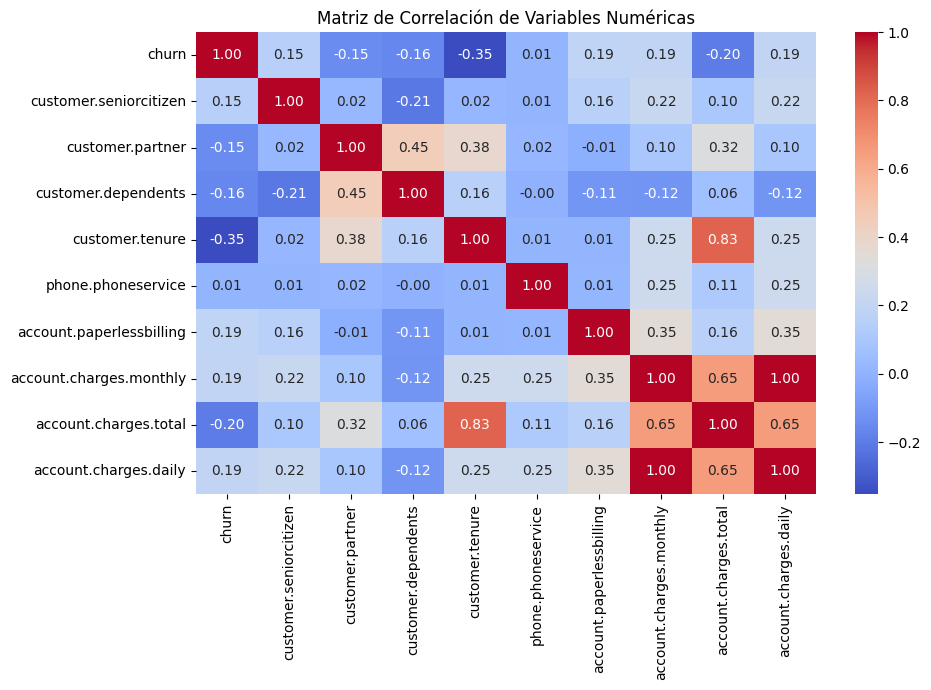

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(numericas.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()


#📄Informe final

**🔹 Introducción**

El presente análisis tiene como objetivo comprender las causas del abandono de clientes (churn) en la empresa ficticia TelecomX, a fin de identificar patrones de comportamiento y factores que influyen en la pérdida de usuarios. La retención de clientes es clave, se ofreceran sugerencias para apalear el abandono

**🔹 Limpieza y Tratamiento de Datos**
Se siguieron los siguientes pasos:

Carga y normalización del JSON

Estandarización textual: Se aplicó limpieza de espacios, minúsculas y se completaron valores faltantes con "unknown" en columnas categóricas.

Eliminación de duplicados y verificación de nulos.

Conversión binaria: Se mapearon valores "yes" a 1, "no" a 0 y "unknown" a NaN para análisis correcto.

Creación de nuevas variables, como:

account.charges.daily: facturación diaria estimada.

Reemplazo de -1 por NaN para evitar distorsiones estadísticas.

Conversión de columnas numéricas mal tipadas, como account.charges.total


**🔹 Análisis Exploratorio de Datos**
Se realizaron diversos análisis visuales y estadísticos para comparar características entre clientes que abandonaron y los que permanecen:

 Gráficos y distribuciones
Tipo de contrato: Los clientes con contrato month-to-month abandonan más (42.71%) que los de contratos anuales (11.27%) o de dos años (7.4%).

Método de pago: Electronic check muestra la tasa más alta de abandono (45.29%).

Tipo de internet: Fiber optic tiene una tasa de abandono de 41.89%, superior a DSL (18.96%).

Servicios adicionales (seguridad, respaldo, soporte): Quienes no cuentan con estos servicios presentan tasas de abandono entre 39% y 42%, contra solo ~15% cuando los tienen.

Facturación: Quienes pagan más mensualmente tienen mayor propensión al abandono, aunque generan menos ingresos totales en el tiempo.

**🔹 Conclusiones e Insights**
Clientes con mayor riesgo de abandono presentan al menos uno o varios de estos factores:

Contrato month-to-month.

Método de pago con electronic check.

Servicio de internet por fibra optica.

Ausencia de servicios adicionales (seguridad, soporte, respaldo).

Alta facturación mensual.

Baja antigüedad (meses contratados).

Sin pareja o dependientes.

Las categorías más asociadas al churn fueron:

Account: variables de contrato, facturación y pago.

Internet: tipo de conexión y servicios complementarios.

Customer: vínculo familiar y antigüedad.

**🔹 Recomendaciones Estratégicas**
Fomentar contratos a largo plazo (1 o 2 años) mediante descuentos, beneficios exclusivos o estabilidad de precios.

Promover métodos de pago automáticos (tarjeta o débito bancario) con incentivos frente al uso de electronic check.

Ofrecer planes atractivos que incluyan servicios adicionales como soporte técnico, respaldo o protección para reducir el churn.

Segmentar a clientes con riesgo alto (poco tiempo de contrato, alta factura mensual) para seguimiento y campañas de fidelización personalizadas.

Realizar encuestas específicas a usuarios de fibra optica para identificar y resolver causas de insatisfacción.

